In [1]:
import keras
import pandas as pd
from glob import glob
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

preprocess_path = "../input/512/"
train_files = glob(os.path.join(preprocess_path, "train/*jpeg"))

df = pd.read_csv("../input/trainLabels.csv")

Using TensorFlow backend.


In [2]:
img_height = 299
img_width = 299
from imgaug import augmenters as iaa

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.2), # horizontally flip 50% of all images
        iaa.Affine(
            scale=(0.9, 1.1),
            rotate=(-180, 180), # rotate by -180 to +180 degrees
        ),
    ],
    random_order=True
)
def get_level(file, df):
    basename = os.path.basename(file)
    image_id = basename.split(".")[0]

    mini_df = df[df['image'] == image_id]
    if len(mini_df) < 1:
        return None

    return mini_df.values[0][1]

# Example: 1 -> [0, 1, 0, 0, 0]
def get_onehot(level):
    level_vec = np.zeros(5)
    level_vec[level] = 1
    
    return level_vec
from keras.utils.data_utils import Sequence

class DataSequence(Sequence):
    def __init__(self, file_list, batch_size, augment=False):
        self.file_list = file_list
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        imgs = []
        labels = []
        
        i = idx * self.batch_size
        
        while len(imgs) < self.batch_size:
            file = self.file_list[i]
            
            level = get_level(file, df)
            if level is None:
                print("missing level: " + file)
                i += 1
                continue
            
            img = cv2.imread(file)
            img = cv2.resize(img,(img_height,img_width))
            
            if img is not None:
                imgs.append(img)
                labels.append(get_onehot(level))
                #class_weights = get_class_weights(current_epoch)

            i += 1

        # Image augmentation
        if self.augment:
            imgs = seq.augment_images(imgs)

        return np.asarray(imgs).astype(np.float16), np.asarray(labels).astype(np.int8)

In [3]:
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

img_channels = 3
img_dim = (img_height, img_width, img_channels)
from datetime import datetime as dt
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'inceptin_{}'.format(time_str)

    return experiment_id
def inceptionv3(img_dim=img_dim):
    input_tensor = Input(shape=img_dim)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=img_dim)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(5, activation='softmax')(x)
    model = Model(input_tensor, output)
    return model

model = inceptionv3()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,041
Trainable params: 21,778,603
Non-trainable params: 34,438
___________________________________________________________

In [4]:
train_files = glob(os.path.join(preprocess_path, "train/*jpeg"))
n_val_files = len(train_files) // 10
val_file_list = train_files[:n_val_files]
train_file_list = train_files[n_val_files:]

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
import datetime
def get_experiment_id():
    time_str = datetime.datetime.now().strftime('%b-%d-%y-%H:%M:%S')
    experiment_id = 'inceptionV3_{}'.format(time_str)

    return experiment_id
get_experiment_id()


'inceptionV3_Nov-06-17-10:19:09'

In [6]:
from keras.utils import multi_gpu_model

# Replicates `model` on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=8)

In [ ]:
parallel_model.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop')

# This `fit` call will be distributed on 8 GPUs.
# Since the batch size is 256, each GPU will process 32 samples.
parallel_model.fit(x, y, epochs=20, batch_size=256)

In [5]:
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
batch_size = 16

train_gen = DataSequence(train_file_list, batch_size, augment=True)
validate_gen = DataSequence(val_file_list, batch_size, augment=True)
#use multigpu 8
#model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])
#parallel_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.003, momentum=0.9, nesterov=True), metrics=['accuracy'])
experiment_id = get_experiment_id()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint("inceptionV3_sgd"+".hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=(len(train_gen)),
                              validation_steps=len(validate_gen),
                              verbose=1,
                              epochs=50,
                              callbacks=callbacks,
                              workers=12, # recommend: number of cpu cores
                              use_multiprocessing=True)

Epoch 1/50
1421/1421 [==============================] - 450s 317ms/step - loss: 0.7123 - acc: 0.7673 - val_loss: 0.7756 - val_acc: 0.7619
Epoch 2/50
1421/1421 [==============================] - 435s 306ms/step - loss: 0.6153 - acc: 0.8017 - val_loss: 0.5968 - val_acc: 0.8069
Epoch 3/50
1421/1421 [==============================] - 435s 306ms/step - loss: 0.5795 - acc: 0.8126 - val_loss: 0.6014 - val_acc: 0.8061
Epoch 4/50
1421/1421 [==============================] - 435s 306ms/step - loss: 0.5585 - acc: 0.8201 - val_loss: 0.6059 - val_acc: 0.7970
Epoch 5/50
1421/1421 [==============================] - 436s 307ms/step - loss: 0.5380 - acc: 0.8260 - val_loss: 0.5754 - val_acc: 0.8221
Epoch 6/50
1421/1421 [==============================] - 436s 307ms/step - loss: 0.5258 - acc: 0.8304 - val_loss: 0.6233 - val_acc: 0.8085
Epoch 7/50
1421/1421 [==============================] - 435s 306ms/step - loss: 0.5116 - acc: 0.8340 - val_loss: 0.6533 - val_acc: 0.7930
Epoch 8/50
1421/1421 [============

In [11]:
model.save(experiment_id + "_final_model.hdf5")

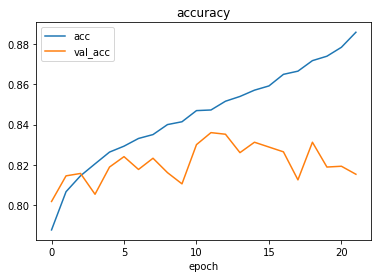

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

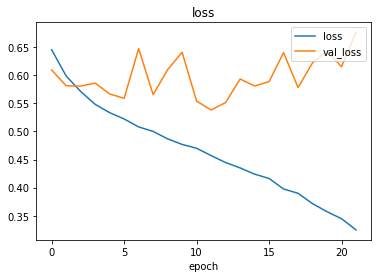

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

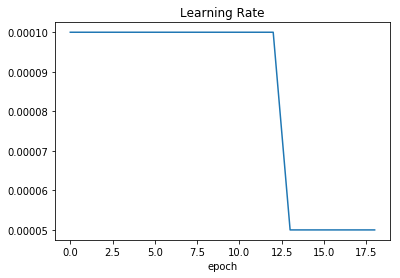

In [14]:
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel('epoch')
plt.show()

In [8]:
model.load_weights("inceptionV3_Nov-06-17-09:27:20-val_loss_checkpoint.hdf5")

In [9]:
y_pred = model.predict_generator(validate_gen, len(validate_gen),verbose=1,workers=20)
y_pred = np.argmax(y_pred, axis=1)

157/157 [==============================] - 66s 419ms/step


In [10]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

y_true = flatten_list([np.argmax(y_true, axis=1) for x, y_true in validate_gen])

In [13]:
import numpy as np
from sklearn import metrics
metrics.accuracy_score(y_pred,y_true)

0.82205414012738853

In [16]:


import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

confusion_table = confusion_matrix(y_true, y_pred)
confusion_table

array([[1818,   16,   33,    0,    6],
       [ 160,   11,   22,    0,    2],
       [ 104,   15,  205,   14,    5],
       [   3,    2,   41,   15,    4],
       [   4,    0,    7,    4,   21]])

In [17]:
y_p=[]
y_t=[]
for var in (y_pred):
    if var>0:
        y_p.append(1)
    else:
        y_p.append(0)
for var in (y_true):
    if var>0:
        y_t.append(1)
    else:
        y_t.append(0)

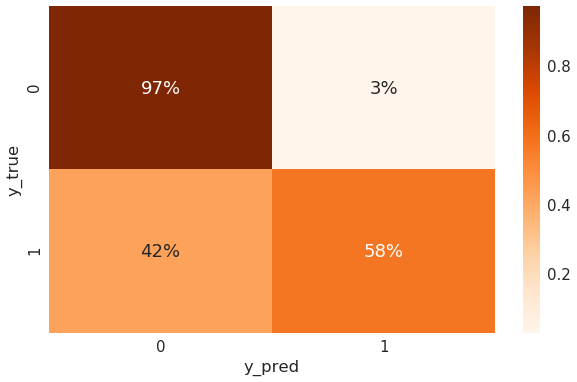

In [18]:
c_table = confusion_matrix(y_t, y_p)
normalized_cf_matrix= c_table / c_table.sum(axis=1, keepdims=True)
df_cmx = pd.DataFrame(normalized_cf_matrix, index=[0, 1], columns=[0, 1])
plt.figure(figsize = (10,6))
sn.set(font_scale=1.5)
ax = sn.heatmap(df_cmx, annot=True, cmap='Oranges', fmt='.0%')
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
plt.show()

In [12]:
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.applications import Xception, InceptionV3

from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
def xception(img_dim=img_dim):
    input_tensor = Input(shape=img_dim)
    base_model = Xception(include_top=False,
                          weights=None,
                   input_shape=img_dim)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(5, activation='softmax')(x)
    model = Model(input_tensor, output)
    return model

model = xception()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 20,871,737
Trainable params: 20,817,203
Non-trainable params: 54,534
___________________________________________________________

## load weight